In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn import tree
from sklearn.inspection import permutation_importance
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ------------------- CLEANING FUNCTION ------------------- #
def run_clean_code():
    AI = pd.read_csv('AI_Resume_Screening.csv')
    AI = AI.replace(np.nan, 'None')
    AIrD = pd.DataFrame(AI)

    # Drop extra columns
    AIrD = AIrD.drop(columns=[col for col in ['Resume_ID', 'Name'] if col in AIrD.columns])

    # Education mapping
    AIrD['Education'] = AIrD['Education'].astype(str).str.strip().str.lower()
    education_mapping = {'b.sc': 1, 'b.tech': 2, 'btech': 2, 'mba': 3, 'm.tech': 4, 'phd': 5}
    AIrD['Education'] = AIrD['Education'].map(education_mapping)
    AIrD = AIrD.dropna(subset=['Education'])

    # Recruiter decision mapping
    AIrD['Recruiter Decision'] = AIrD['Recruiter Decision'].astype(str).str.strip().str.lower()
    AIrD['Recruiter Decision'] = AIrD['Recruiter Decision'].map({'hire': 1, 'reject': 0})
    AIrD = AIrD.dropna(subset=['Recruiter Decision'])

    # Certifications mapping
    cert_map = {'None': 0, 'Google ML': 1, 'Deep Learning Specialization': 2, 'AWS Certified': 3}
    AIrD['Certifications'] = AIrD['Certifications'].map(cert_map).fillna(0)

    AIrD = AIrD.reset_index(drop=True)
    return AIrD

# ------------------- LOAD & CLEAN DATA ------------------- #
AIrD = run_clean_code()

In [27]:
# ------------------- HYPOTHESIS 1: Most Influential Features ------------------- #
X = AIrD[['AI Score (0-100)', 'Experience (Years)', 'Education']]
y = AIrD['Recruiter Decision']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

coeff_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': log_reg.coef_[0]})
print("\nLogistic Regression Coefficients:")
print(coeff_df.sort_values(by='Coefficient', key=abs, ascending=False))

# Decision Tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

feat_imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': clf.feature_importances_})
print("\nDecision Tree Feature Importance:")
print(feat_imp_df.sort_values(by='Importance', ascending=False))

# ------------------ H1: Feature Importance ------------------ #
X = AIrD[['AI Score (0-100)', 'Experience (Years)', 'Education']]
y = AIrD['Recruiter Decision']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

perm_importance = permutation_importance(log_reg, X_test, y_test, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({'Feature': X.columns, 'Permutation Importance': perm_importance.importances_mean})
top_features = perm_df.sort_values(by='Permutation Importance', ascending=False)



Logistic Regression Coefficients:
              Feature  Coefficient
0    AI Score (0-100)     1.806346
2           Education     0.055866
1  Experience (Years)     0.037022

Decision Tree Feature Importance:
              Feature  Importance
0    AI Score (0-100)         1.0
1  Experience (Years)         0.0
2           Education         0.0



AI-Recruiter Alignment: 92.90%


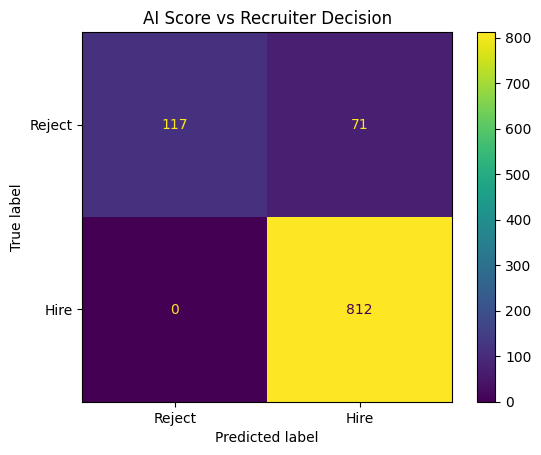

In [28]:
# ------------------ H2: AI Score Alignment ------------------ #
AIrD['AI Predicted'] = AIrD['AI Score (0-100)'].apply(lambda x: 1 if x > 50 else 0)
alignment = (AIrD['AI Predicted'] == AIrD['Recruiter Decision']).sum()
alignment_pct = alignment / len(AIrD) * 100

print(f"\nAI-Recruiter Alignment: {alignment_pct:.2f}%")

cm = confusion_matrix(AIrD['Recruiter Decision'], AIrD['AI Predicted'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Reject', 'Hire'])
disp.plot()
plt.title("AI Score vs Recruiter Decision")
plt.show()

# ------------------ H2: AI Score Alignment ------------------ #
thresholds = np.arange(30, 71, 5)
alignment_scores = []
for t in thresholds:
    predicted = AIrD['AI Score (0-100)'].apply(lambda x: 1 if x >= t else 0)
    precision = precision_score(AIrD['Recruiter Decision'], predicted)
    recall = recall_score(AIrD['Recruiter Decision'], predicted)
    alignment = (predicted == AIrD['Recruiter Decision']).mean() * 100
    alignment_scores.append((t, alignment, precision, recall))

best_threshold = max(alignment_scores, key=lambda x: x[1])

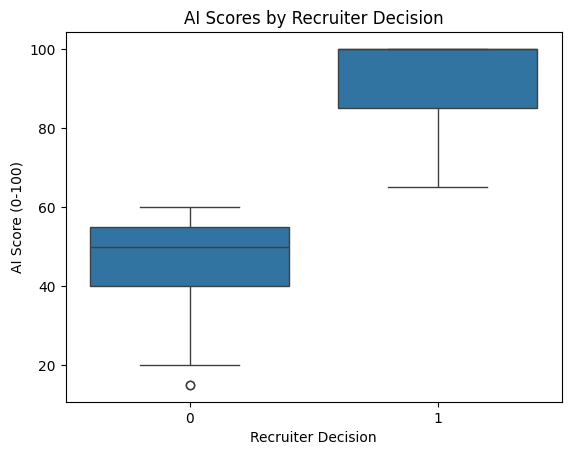

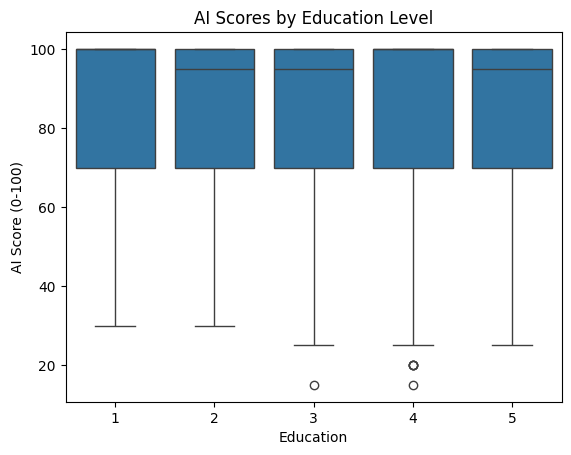


T-test for AI Score bias: t = 49.02, p = 0.0000


In [29]:
# ------------------- HYPOTHESIS 3: Bias in AI Scores ------------------- #
# AI Score by Recruiter Decision
sns.boxplot(data=AIrD, x='Recruiter Decision', y='AI Score (0-100)')
plt.title("AI Scores by Recruiter Decision")
plt.show()

# AI Score by Education Level
sns.boxplot(data=AIrD, x='Education', y='AI Score (0-100)')
plt.title("AI Scores by Education Level")
plt.show()

# T-test for score bias
hired_scores = AIrD[AIrD['Recruiter Decision'] == 1]['AI Score (0-100)']
rejected_scores = AIrD[AIrD['Recruiter Decision'] == 0]['AI Score (0-100)']
t_stat, p_val = ttest_ind(hired_scores, rejected_scores)
print(f"\nT-test for AI Score bias: t = {t_stat:.2f}, p = {p_val:.4f}")

# ------------------ H3: Bias Testing ------------------ #
hired_scores = AIrD[AIrD['Recruiter Decision'] == 1]['AI Score (0-100)']
rejected_scores = AIrD[AIrD['Recruiter Decision'] == 0]['AI Score (0-100)']
t_stat, p_val = ttest_ind(hired_scores, rejected_scores)

def cohens_d(g1, g2):
    return (g1.mean() - g2.mean()) / np.sqrt((g1.std()**2 + g2.std()**2) / 2)

cohen_d = cohens_d(hired_scores, rejected_scores)

model = ols('Q("AI Score (0-100)") ~ C(Education)', data=AIrD).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

In [30]:
# ------------------ Print Summary ------------------ #
print("Top Influential Resume Features (H1):")
print(top_features.head(2), "\n")

print(f"Best AI-Recruiter Alignment (H2):")
print(f"- Threshold: {best_threshold[0]}")
print(f"- Alignment: {best_threshold[1]:.2f}%")
print(f"- Precision: {best_threshold[2]:.2f}")
print(f"- Recall: {best_threshold[3]:.2f}\n")

print("Bias Analysis (H3):")
print(f"- T-test: p = {p_val:.4f}")
print(f"- Cohen’s d: {cohen_d:.2f} (small=0.2, medium=0.5, large=0.8)\n")
print("- ANOVA by Education Level:")
print(anova_table)

# Real labels
X_real = AIrD[['AI Score (0-100)', 'Experience (Years)', 'Education']]
y_real = AIrD['Recruiter Decision']
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real, y_real, test_size=0.2, random_state=42)

model_real = LogisticRegression()
model_real.fit(X_train_real, y_train_real)
real_accuracy = model_real.score(X_test_real, y_test_real)

# Shuffled labels
AIrD['Shuffled Recruiter'] = AIrD['Recruiter Decision'].sample(frac=1.0, random_state=42).reset_index(drop=True)
y_shuffled = AIrD['Shuffled Recruiter']
X_train_shuf, X_test_shuf, y_train_shuf, y_test_shuf = train_test_split(X_real, y_shuffled, test_size=0.2, random_state=42)

model_shuffled = LogisticRegression()
model_shuffled.fit(X_train_shuf, y_train_shuf)
shuffled_accuracy = model_shuffled.score(X_test_shuf, y_test_shuf)

Top Influential Resume Features (H1):
              Feature  Permutation Importance
0    AI Score (0-100)                   0.349
1  Experience (Years)                   0.000 

Best AI-Recruiter Alignment (H2):
- Threshold: 65
- Alignment: 100.00%
- Precision: 1.00
- Recall: 1.00

Bias Analysis (H3):
- T-test: p = 0.0000
- Cohen’s d: 4.01 (small=0.2, medium=0.5, large=0.8)

- ANOVA by Education Level:
                     sum_sq     df         F    PR(>F)
C(Education)     258.029194    4.0  0.146011  0.964775
Residual      439589.470806  995.0       NaN       NaN


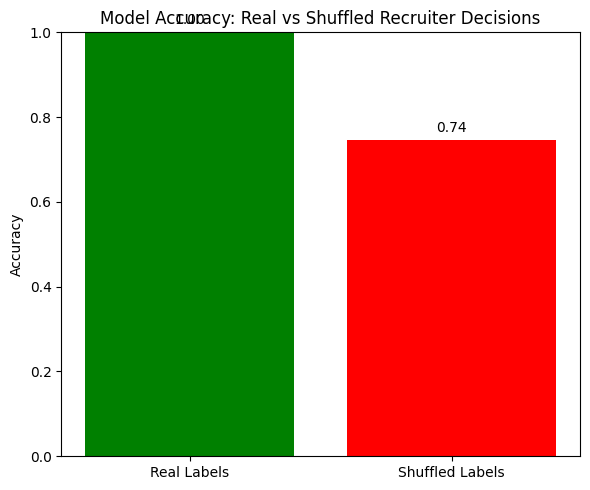

In [31]:
# Plot it!
plt.figure(figsize=(6, 5))
plt.bar(['Real Labels', 'Shuffled Labels'], [real_accuracy, shuffled_accuracy], color=['green', 'red'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy: Real vs Shuffled Recruiter Decisions')
plt.ylim(0, 1)
plt.tight_layout()
plt.text(0, real_accuracy + 0.02, f"{real_accuracy:.2f}", ha='center')
plt.text(1, shuffled_accuracy + 0.02, f"{shuffled_accuracy:.2f}", ha='center')

plt.show()